  Using cached xgboost-3.0.1-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.1-py3-none-win_amd64.whl (150.0 MB)
Linear Regression: R^2 mean=0.9973, std=0.0002
Random Forest: R^2 mean=0.9770, std=0.0024
XGBoost: R^2 mean=0.9867, std=0.0011


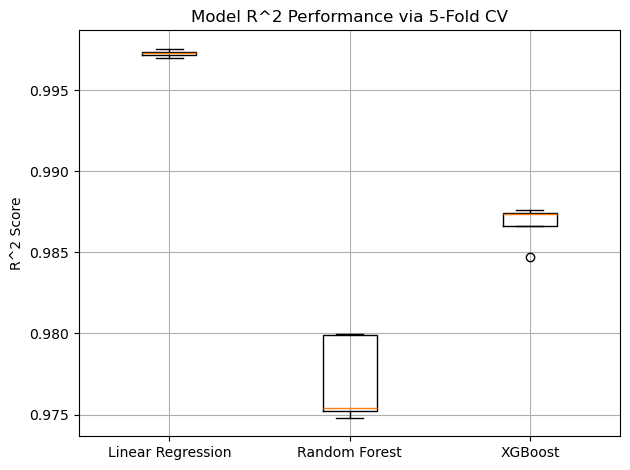

In [1]:
# Utah Tax Model Training with Cross-Validation (Jupyter-Friendly)
!pip install xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# 1. Generate synthetic Utah-specific dataset
np.random.seed(42)
n_samples = 1000

wages = np.random.randint(20000, 150000, n_samples)
children = np.random.randint(0, 4, n_samples)
deductions = np.random.randint(0, 30000, n_samples)
pay_freqs = np.random.choice(['weekly', 'biweekly', 'monthly'], n_samples)
raise_percent = np.random.uniform(0, 0.25, n_samples)
time_of_year = np.random.randint(1, 13, n_samples)  # Month
itemized = np.random.choice([0, 1], n_samples)

adjusted_wages = wages * (1 + raise_percent) - deductions
target = adjusted_wages * 0.08 - children * 2000 - itemized * 1500

# 2. Create DataFrame
X = pd.DataFrame({
    'wages': wages,
    'num_children': children,
    'pre_tax_deductions': deductions,
    'pay_frequency': pay_freqs,
    'projected_raise_pct': raise_percent,
    'month': time_of_year,
    'itemized_deductions': itemized
})

y = target

# One-hot encode categorical
X = pd.get_dummies(X, columns=['pay_frequency'], drop_first=True)

# 3. Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# 4. K-Fold CV and evaluation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    scores = cross_val_score(model, X, y, scoring='r2', cv=kfold)
    results[name] = scores
    print(f"{name}: R^2 mean={scores.mean():.4f}, std={scores.std():.4f}")

# 5. Final training and save models
for name, model in models.items():
    model.fit(X, y)
    filename = f"model_{name.lower().replace(' ', '_')}_utah.pkl"
    joblib.dump(model, filename)

# 6. Plotting
fig, ax = plt.subplots()
ax.boxplot(results.values(), labels=results.keys())
ax.set_title("Model R^2 Performance via 5-Fold CV")
ax.set_ylabel("R^2 Score")
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
import numpy as np

np.random.seed(42)
n = 1000

df = pd.DataFrame({
    'wages': np.random.randint(30000, 150000, n),
    'num_children': np.random.randint(0, 5, n),
    'pre_tax_deductions': np.random.randint(0, 20000, n),
    'itemized_deductions': np.random.choice([0, 1], n),
    'raise_percent': np.random.uniform(0, 20, n),
    'months_elapsed': np.random.randint(1, 13, n),
    'pay_frequency': np.random.choice(['weekly', 'biweekly', 'monthly'], n)
})

df = pd.get_dummies(df, columns=['pay_frequency'])

df['adjusted_wages'] = df['wages'] * (1 + df['raise_percent'] / 100) * df['months_elapsed'] / 12
df['tax'] = (
    0.15 * df['adjusted_wages']
    - 1000 * df['num_children']
    - df['pre_tax_deductions']
    - 2000 * df['itemized_deductions']
)

df.to_csv("synthetic_utah_tax_data.csv", index=False)
print("Saved to 'synthetic_utah_tax_data.csv'")


Saved to 'synthetic_utah_tax_data.csv'


In [3]:
import pandas as pd

# Load the synthetic Utah tax dataset
df = pd.read_csv("synthetic_utah_tax_data.csv")

# Preview the first few rows
df.head()


,wages,num_children,pre_tax_deductions,itemized_deductions,raise_percent,months_elapsed,pay_frequency_biweekly,pay_frequency_monthly,pay_frequency_weekly,adjusted_wages,tax
0,45795,1,3453,0,18.121318,3,True,False,False,13523.414362,-2424.487846
1,30860,2,6675,0,5.333504,6,False,False,True,16252.959657,-6237.056051
2,133694,2,955,1,14.497130,8,False,True,False,102050.528643,10352.579296
3,149879,1,6295,0,17.552940,9,True,False,False,132140.378649,12526.056797
4,140268,3,15921,0,0.833136,1,False,True,False,11786.385310,-17153.042203


In [5]:
# Convert Boolean columns to integers (optional but cleaner)
for col in df.select_dtypes("bool").columns:
    df[col] = df[col].astype(int)
# Add 'adjusted_wages' and compute synthetic 'target'
df["adjusted_wages"] = df["wages"] * (1 + df["raise_percent"] / 100) - df["pre_tax_deductions"]
df["target"] = df["adjusted_wages"] * 0.08 - df["num_children"] * 2000 - df["itemized_deductions"] * 1500

# Define X and y
X = df.drop(columns=["target"])
y = df["target"]

# Check structure
print("Feature columns:\n", X.columns.tolist())
X.head()


Feature columns:
 ['wages', 'num_children', 'pre_tax_deductions', 'itemized_deductions', 'raise_percent', 'months_elapsed', 'pay_frequency_biweekly', 'pay_frequency_monthly', 'pay_frequency_weekly', 'adjusted_wages', 'tax']


,wages,num_children,pre_tax_deductions,itemized_deductions,raise_percent,months_elapsed,pay_frequency_biweekly,pay_frequency_monthly,pay_frequency_weekly,adjusted_wages,tax
0,45795,1,3453,0,18.121318,3,1,0,0,50640.657447,-2424.487846
1,30860,2,6675,0,5.333504,6,0,0,1,25830.919314,-6237.056051
2,133694,2,955,1,14.497130,8,0,1,0,152120.792964,10352.579296
3,149879,1,6295,0,17.552940,9,1,0,0,169892.171532,12526.056797
4,140268,3,15921,0,0.833136,1,0,1,0,125515.623720,-17153.042203


Linear Regression: R^2 mean=1.0000, std=0.0000
Random Forest: R^2 mean=0.9942, std=0.0005
XGBoost: R^2 mean=0.9956, std=0.0011


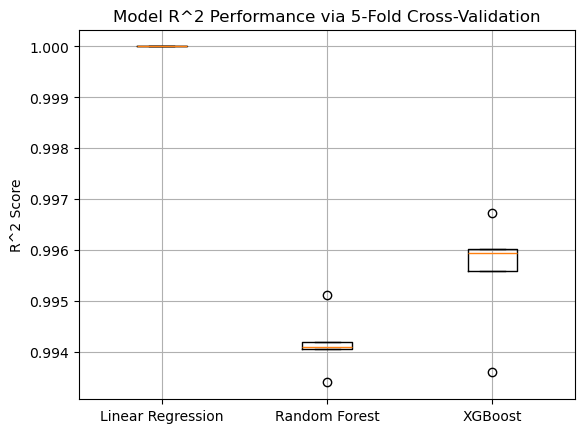

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

# Set up 5-Fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scorer = make_scorer(r2_score)

# Evaluate models
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, scoring=r2_scorer, cv=cv)
    results[name] = scores
    print(f"{name}: R^2 mean={scores.mean():.4f}, std={scores.std():.4f}")

# Boxplot to compare model performance
plt.boxplot(results.values(), labels=results.keys())
plt.ylabel("R^2 Score")
plt.title("Model R^2 Performance via 5-Fold Cross-Validation")
plt.grid(True)
plt.show()


In [7]:
import numpy as np
import pandas as pd

# Load existing dataset
df = pd.read_csv("synthetic_utah_tax_data.csv")

# Add noise to synthetic target (Option 2)
np.random.seed(42)
noise = np.random.normal(loc=0, scale=100, size=len(df))
df["target_with_noise"] = (
    df["wages"] * (1 + df["raise_percent"] / 100)
    - df["pre_tax_deductions"]
) * 0.08 - df["num_children"] * 2000 - df["itemized_deductions"] * 1500 + noise

# Add progressive tax bracket logic (Option 3)
def compute_bracket_tax(adjusted_income):
    brackets = [(0, 15000, 0.05), (15000, 40000, 0.07), (40000, 100000, 0.09), (100000, float('inf'), 0.1)]
    tax = 0
    for lower, upper, rate in brackets:
        if adjusted_income > lower:
            taxed_amount = min(upper, adjusted_income) - lower
            tax += taxed_amount * rate
    return tax

# Create adjusted income column
df["adjusted_wages"] = df["wages"] * (1 + df["raise_percent"] / 100) - df["pre_tax_deductions"]
df["target_tax_bracket"] = df["adjusted_wages"].apply(compute_bracket_tax)

# Preview
df[["wages", "adjusted_wages", "target_with_noise", "target_tax_bracket"]].head()


,wages,adjusted_wages,target_with_noise,target_tax_bracket
0,45795,50640.657447,2100.924011,3457.659170
1,30860,25830.919314,-1947.352885,1508.164352
2,133694,152120.792964,6734.432291,13112.079296
3,149879,169892.171532,11743.676708,14889.217153
4,140268,125515.623720,4017.834560,10451.562372



🔍 Evaluating Target: Noisy Target
Linear Regression: R² mean=0.9979, std=0.0002
Random Forest: R² mean=0.9822, std=0.0015
XGBoost: R² mean=0.9894, std=0.0015

🔍 Evaluating Target: Bracket Target
Linear Regression: R² mean=0.9950, std=0.0003
Random Forest: R² mean=0.9951, std=0.0008
XGBoost: R² mean=0.9967, std=0.0002


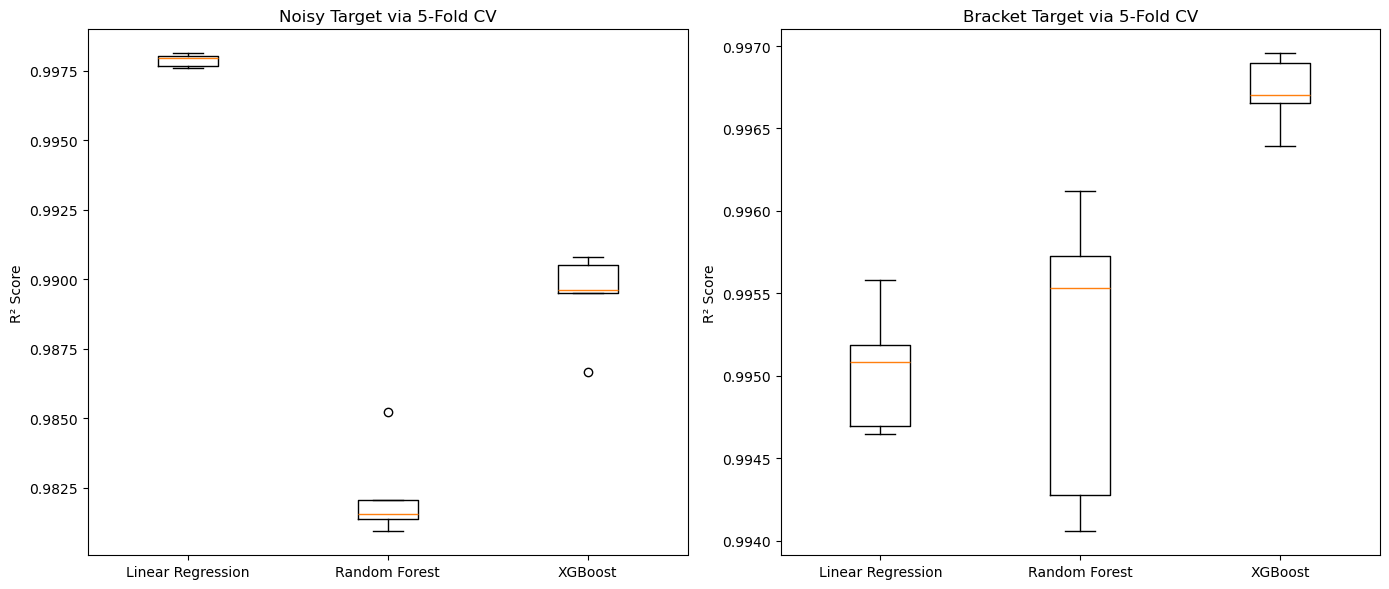

In [8]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Prepare features
feature_cols = [
    "wages", "num_children", "pre_tax_deductions", "itemized_deductions",
    "raise_percent", "months_elapsed",
    "pay_frequency_biweekly", "pay_frequency_monthly", "pay_frequency_weekly"
]
X = df[feature_cols]

# Two targets to evaluate
targets = {
    "Noisy Target": df["target_with_noise"],
    "Bracket Target": df["target_tax_bracket"]
}

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for target_name, y in targets.items():
    print(f"\n🔍 Evaluating Target: {target_name}")
    results[target_name] = []
    for model_name, model in models.items():
        scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
        results[target_name].append(scores)
        print(f"{model_name}: R² mean={scores.mean():.4f}, std={scores.std():.4f}")

# 📈 Plotting results
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for i, (target_name, model_scores) in enumerate(results.items()):
    ax[i].boxplot(model_scores, labels=models.keys())
    ax[i].set_title(f"{target_name} via 5-Fold CV")
    ax[i].set_ylabel("R² Score")
plt.tight_layout()
plt.show()
